Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**DaVinci.jpg**

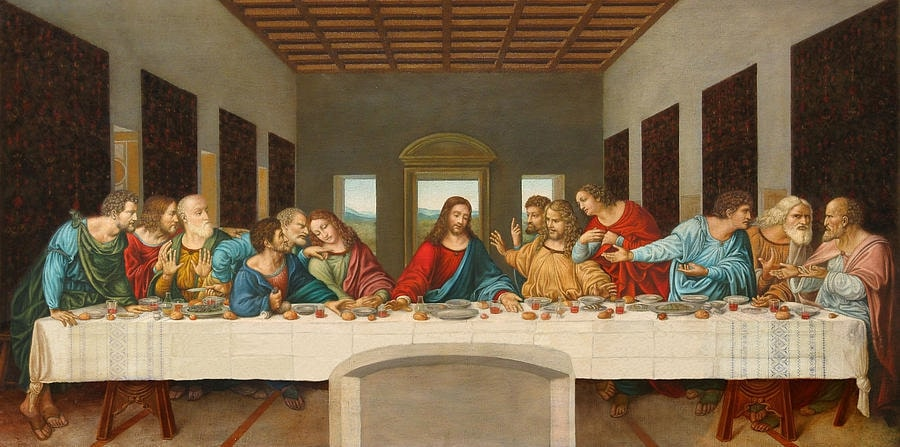

**DagnanBouveret.jpg**

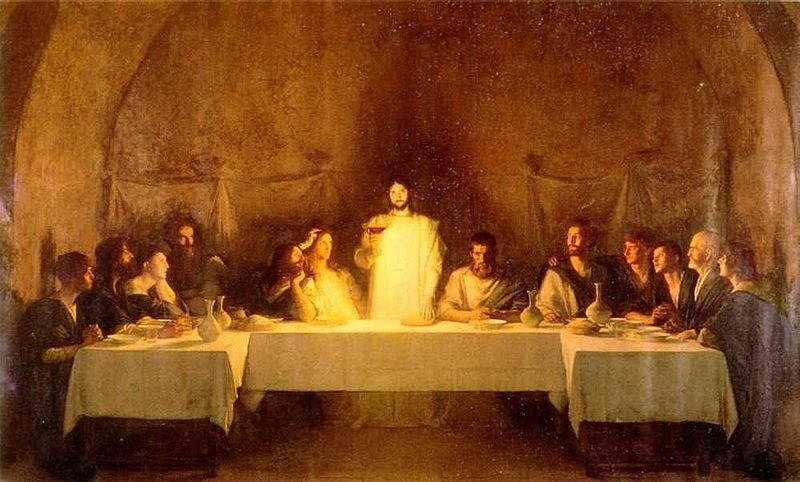

**Dali.jpg**

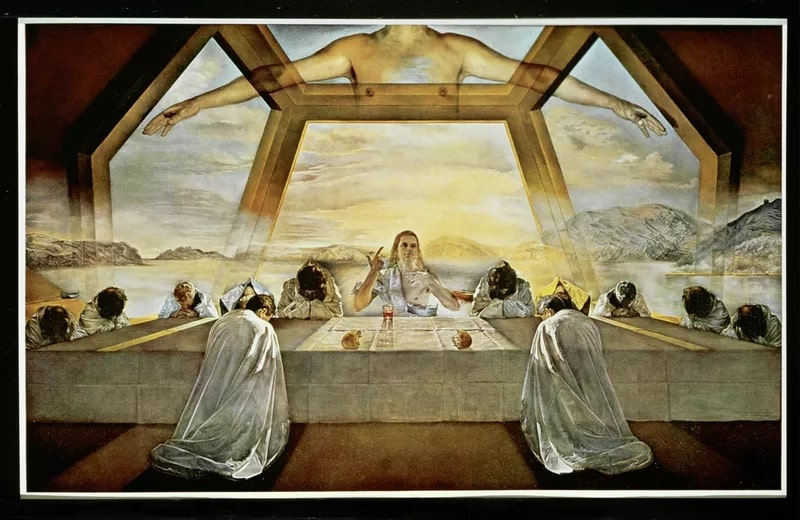

**Souza.jpg**

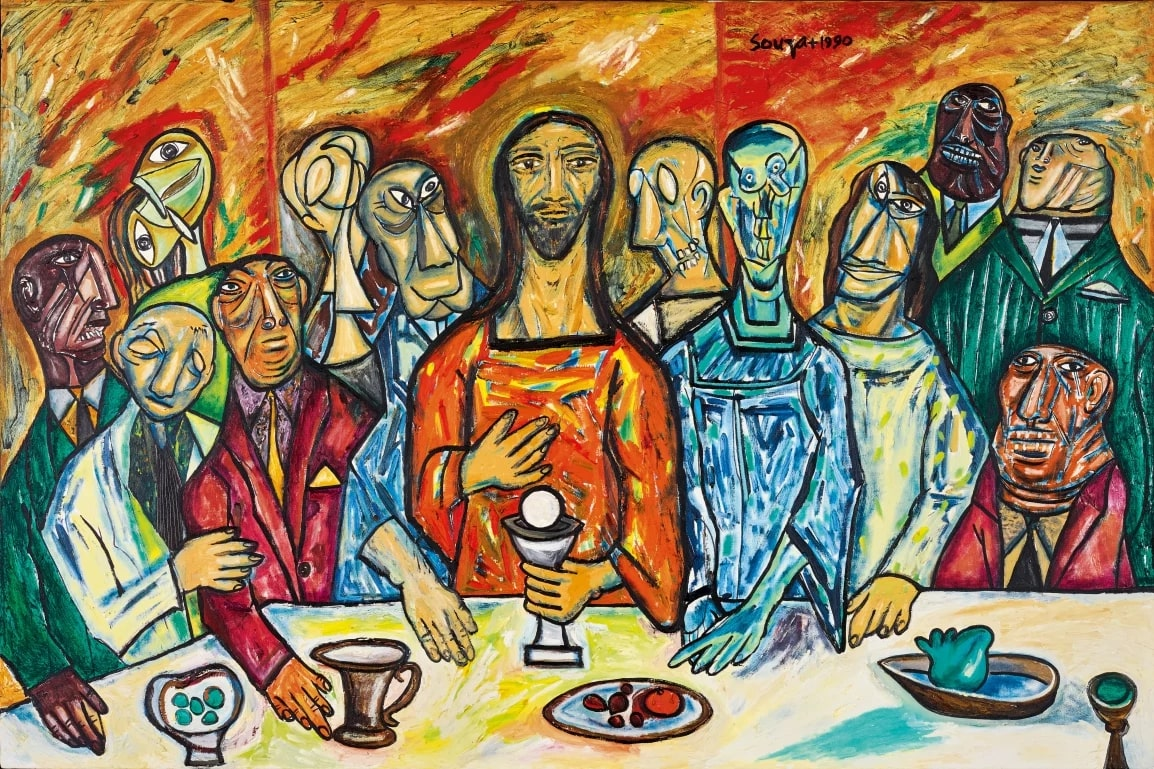

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('/content')

from google.colab import drive
drive.mount('/content/drive')

import base64
from IPython.display import display, Markdown

#for markdown
def display_base64_image(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode()
        display(Markdown(f"![image alt text](data:image/png;base64,{encoded_string})"))

# Display input images
input_images = ["DaVinci.jpg", "DagnanBouveret.jpg", "Dali.jpg", "Souza.jpg"]
for image_name in input_images:
  display(Markdown(f"**{image_name}**"))
  display_base64_image(image_name)


#preprocess input image so it's compatible with the VGG19 network
def preprocess_image(image_path, target_size=(400, 400)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

#deprocess the image to revert preprocessing done earlier
def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

#build the neural style transfer model using VGG19
def build_nst_model(content_image, style_image):
    content_layer = 'block5_conv2'
    style_layers = [
        'block1_conv1',
        'block2_conv1',
        'block3_conv1',
        'block4_conv1',
        'block5_conv1',
    ]

    vgg = vgg19.VGG19(weights='imagenet', include_top=False)
    content_model = Model(vgg.input, vgg.get_layer(content_layer).output)
    style_models = [Model(vgg.input, vgg.get_layer(layer).output) for layer in style_layers]

    content_image = preprocess_image(content_image)
    style_image = preprocess_image(style_image)

    content_target = content_model.predict(content_image)
    style_targets = [model.predict(style_image) for model in style_models]

    return vgg, content_model, style_models, content_target, style_targets

#calculate content loss
def content_loss(content, target):
    return tf.reduce_mean(tf.square(content - target))

#calculate gram matrix
def gram_matrix(x):
    features = tf.keras.backend.batch_flatten(tf.keras.backend.permute_dimensions(x, (2, 0, 1)))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

#calculate style loss
def style_loss(style_features, style_target):
    height, width, channels = style_features.shape[1:]
    gram_style_features = gram_matrix(style_features[0])
    gram_style_target = gram_matrix(style_target[0])
    return tf.reduce_sum(tf.square(gram_style_features - gram_style_target)) / (4.0 * (channels ** 2) * (width * height) ** 2)

#calculate total variation loss
def total_variation_loss(x):
    a = tf.square(x[:, : -1, : -1, :] - x[:, 1:, : -1, :])
    b = tf.square(x[:, : -1, : -1, :] - x[:, : -1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

#compute the loss for NST
def compute_loss(x, vgg, content_model, style_models, content_target, style_targets, content_weight=1.0, style_weight=1e4, variation_weight=1e-5):
    x_tensor = tf.convert_to_tensor(x)

    content_features = content_model(x_tensor)
    style_features = [model(x_tensor) for model in style_models]

    c_loss = content_loss(content_features, content_target)
    s_loss = sum(style_loss(sf, st) for sf, st in zip(style_features, style_targets))
    v_loss = total_variation_loss(x_tensor)
    loss = content_weight * c_loss + style_weight * s_loss + variation_weight * v_loss

    return loss

def run_nst(content_image, style_image, output_image, iterations=100, step_size=10.0):
    vgg, content_model, style_models, content_target, style_targets = build_nst_model(content_image, style_image)
    content_image = preprocess_image(content_image)
    x = tf.Variable(content_image, dtype=tf.float32)

    optimizer = Adam(learning_rate=step_size)

    for i in range(iterations):
        with tf.GradientTape() as tape:
            loss = compute_loss(x, vgg, content_model, style_models, content_target, style_targets)
        grads = tape.gradient(loss, x)
        optimizer.apply_gradients([(grads, x)])

        if (i + 1) % 10 == 0:
            print(f'Iteration {i + 1}/{iterations}: loss={loss:.2f}')
            result = x.numpy().squeeze()
            result = deprocess_image(result)
            plt.imsave(f'{output_image}_iter{i+1}.jpg', result)

    result = x.numpy().squeeze()
    result = deprocess_image(result)
    plt.imsave(output_image, result)

**DaVinci.jpg**

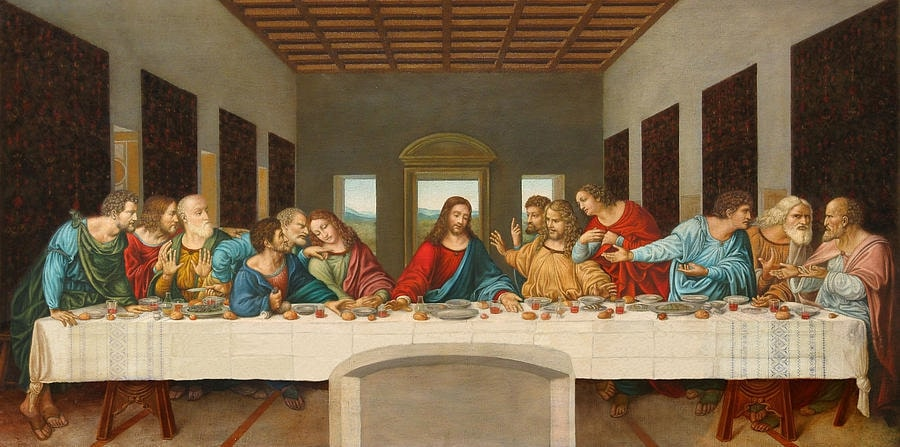

**DagnanBouveret.jpg**

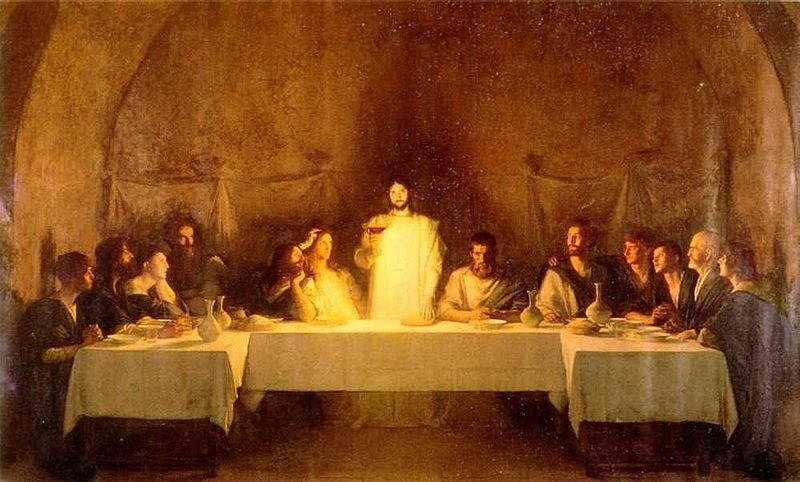

**Dali.jpg**

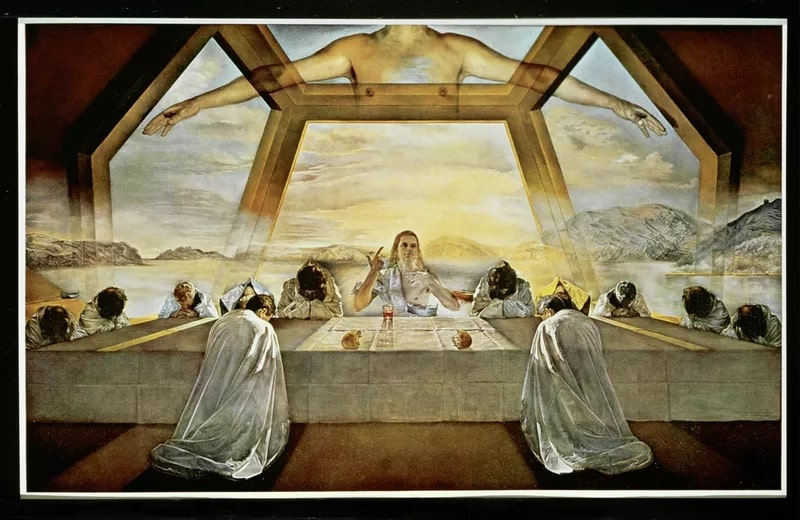

**Souza.jpg**

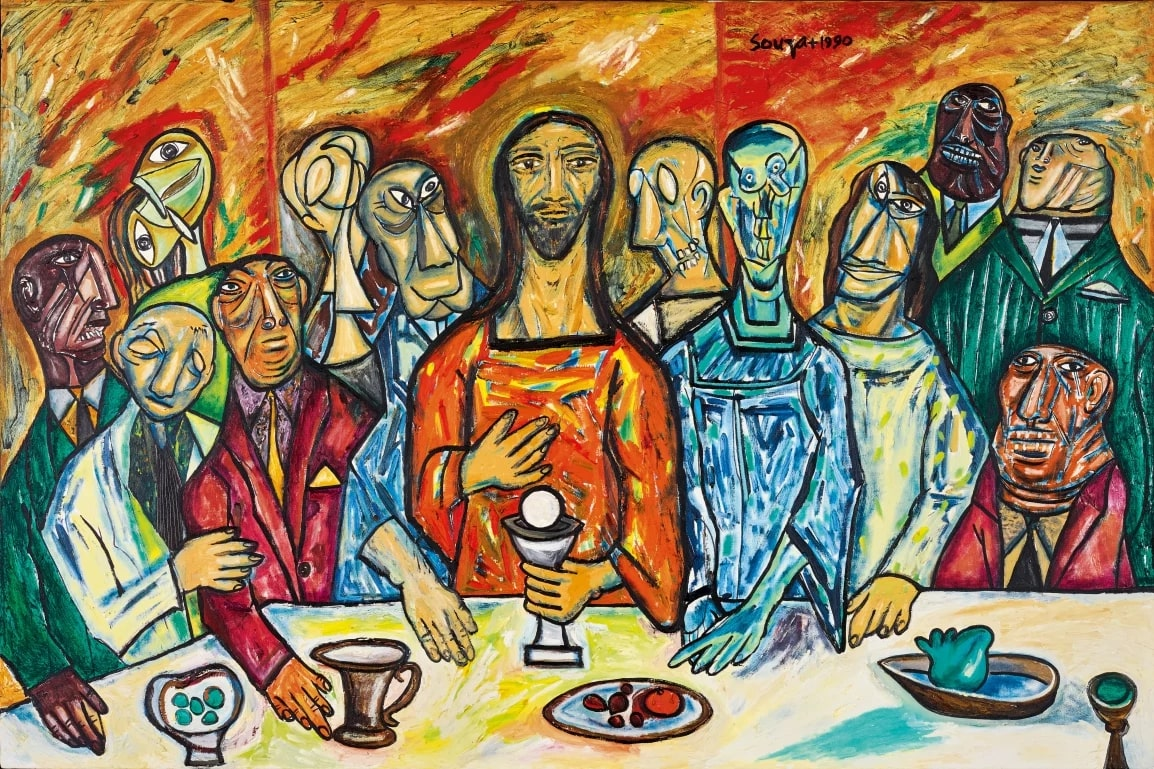

Starting NST for dagnan_bouveret
1/1 [==============================] - 1s 531ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step
Iteration 10/100: loss=31032743034880.00
Iteration 20/100: loss=9617856790528.00
Iteration 30/100: loss=3994057965568.00
Iteration 40/100: loss=2146396798976.00
Iteration 50/100: loss=1346697428992.00
Iteration 60/100: loss=964740448256.00
Iteration 70/100: loss=749350354944.00
Iteration 80/100: loss=613046419456.00
Iteration 90/100: loss=519483981824.00
Iteration 100/100: loss=451807379456.00
Finished NST for dagnan_bouveret


**output/dagnan_bouveret_last_supper.jpg**

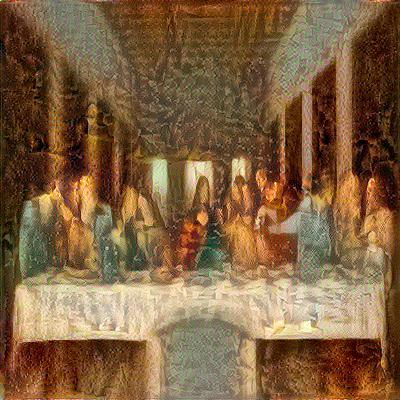

Starting NST for dali
1/1 [==============================] - 1s 1s/step
Iteration 10/100: loss=34239464603648.00
Iteration 20/100: loss=16780696223744.00
Iteration 30/100: loss=9930049323008.00
Iteration 40/100: loss=6624701841408.00
Iteration 50/100: loss=4870701580288.00
Iteration 60/100: loss=3852806127616.00
Iteration 70/100: loss=3211879776256.00
Iteration 80/100: loss=2773506850816.00
Iteration 90/100: loss=2716148695040.00
Iteration 100/100: loss=2404848500736.00
Finished NST for dali


**output/dali_last_supper.jpg**

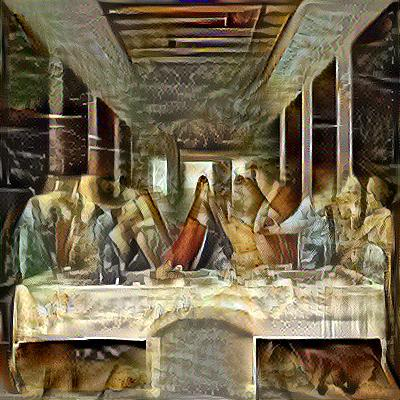

Starting NST for souza
1/1 [==============================] - 1s 1s/step
Iteration 10/100: loss=80381890002944.00
Iteration 20/100: loss=29027507109888.00
Iteration 30/100: loss=16220405366784.00
Iteration 40/100: loss=10260872953856.00
Iteration 50/100: loss=7135524552704.00
Iteration 60/100: loss=5401129517056.00
Iteration 70/100: loss=4358027083776.00
Iteration 80/100: loss=3670940057600.00
Iteration 90/100: loss=3189960343552.00
Iteration 100/100: loss=2833276993536.00
Finished NST for souza


**output/souza_last_supper.jpg**

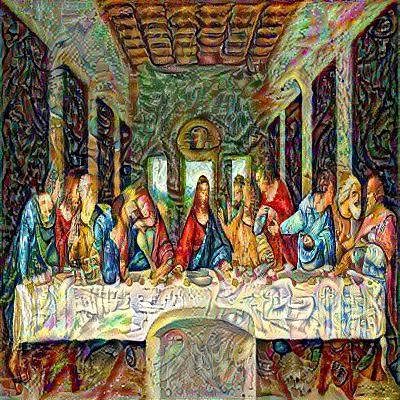

In [ ]:
if __name__ == '__main__':
    # Paths to images
    content_image = 'DaVinci.jpg'
    style_images = {
        'dagnan_bouveret': 'DagnanBouveret.jpg',
        'dali': 'Dali.jpg',
        'souza': 'Souza.jpg'
    }

    image_folder = '/content/drive/MyDrive/Colab Notebooks/PROJECT IMGS'
    output_dir = 'output'
    os.makedirs(output_dir, exist_ok=True)

    input_images = [content_image] + list(style_images.values())
    for image_name in input_images:
        image_path = os.path.join(image_folder, image_name)
        display(Markdown(f"**{image_name}**"))
        display_base64_image(image_path)

    for style_name, style_image in style_images.items():
        output_image = os.path.join(output_dir, f'{style_name}_last_supper.jpg')
        print(f'Starting NST for {style_name}')
        content_image_path = os.path.join(image_folder, content_image)
        style_image_path = os.path.join(image_folder, style_image)
        run_nst(content_image_path, style_image_path, output_image)
        print(f'Finished NST for {style_name}')
        display(Markdown(f"**{output_image}**"))
        display_base64_image(output_image)
